<a href="https://colab.research.google.com/github/Phunbie/Phunbie/blob/main/benchmark_bond_trade_price_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('benchmark-bond-trade-price-challenge')
jovian.set_colab_id('1ZFY9QSlpXR9IstsDF_BMBbXxumKrTsBf')

# benchmark-bond-trade-price-challenge

Use the "Run" button to execute the code.

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="benchmark-bond-trade-price-challenge")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/adeneyeoluwafunbi/benchmark-bond-trade-price-challenge


'https://jovian.ai/adeneyeoluwafunbi/benchmark-bond-trade-price-challenge'

#Problem Statement
The Benchmark Bond Trade Price Challenge is a competition to predict the next price that a US corporate bond might trade at. Contestants are given information on the bond including current coupon, time to maturity and a reference price computed by Benchmark Solutions. 

US corporate bond trade data is provided.  Each row includes trade details, some basic information about the traded bond, and information about the previous 10 trades.  Contestants are asked to predict trade price.

**id**: The row id.

**bond_id**: The unique id of a bond to aid in timeseries reconstruction. (This column is only present in the train data)

**trade_price**: The price at which the trade occured.  (This is the column to predict in the test data)

**weight**: The weight of the row for evaluation purposes. This is calculated as the square root of the time since the last trade and then scaled so the mean is 1.

**current_coupon**: The coupon of the bond at the time of the trade.

time_to_maturity: The number of years until the bond matures at the time of the trade.

**is_callable**: A binary value indicating whether or not the bond is callable by the issuer.

**reporting_delay**: The number of seconds after the trade occured that it was reported.

**trade_size**: The notional amount of the trade.

**trade_type**: 2=customer sell, 3=customer buy, 4=trade between dealers. We would expect customers to get worse prices on average than dealers.

**curve_based_price**: A fair price estimate based on implied hazard and funding curves of the issuer of the bond.

**received_time_diff_last{1-10}**: The time difference between the trade and that of the previous {1-10}.

**trade_price_last{1-10}**: The trade price of the last {1-10} trades.

**trade_size_last{1-10}**: The notional amount of the last {1-10} trades.

**trade_type_last{1-10}**: The trade type of the last {1-10} trades.

**curve_based_price_last{1-10}**: The curve based price of the last {1-10} trades.

This is definately a regression supervised machine learning problem. We will use several regression  machine learning model, tune each model's hyperparameters and select the model that has the best prediction.



#Downloading the Data 
To begin, let's download the data using the urlretrieve function from urllib.request.

In [ ]:
!pip install opendatasets
import os
import opendatasets as od
import pandas as pd

In [ ]:
od.download('https://www.kaggle.com/c/benchmark-bond-trade-price-challenge')

Skipping, found downloaded files in "./benchmark-bond-trade-price-challenge" (use force=True to force download)


The next code shows all the files available for download

In [ ]:
os.listdir('benchmark-bond-trade-price-challenge')

['test.zip',
 'train.csv',
 'train.7z',
 'train.zip',
 'test.mat',
 'old_data.zip',
 'test.csv',
 'test.7z',
 'train.mat',
 'random_forest_sample_submission.csv',
 'random_forest_benchmark.r']

In [ ]:
train_main =  pd.read_csv('./benchmark-bond-trade-price-challenge/train.csv')
test_df =  pd.read_csv('./benchmark-bond-trade-price-challenge/test.csv')

###Now let's have an overview of our datasets.

In [ ]:
train_main

,id,bond_id,trade_price,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,curve_based_price,received_time_diff_last1,trade_price_last1,trade_size_last1,trade_type_last1,curve_based_price_last1,received_time_diff_last2,trade_price_last2,trade_size_last2,trade_type_last2,curve_based_price_last2,received_time_diff_last3,trade_price_last3,trade_size_last3,trade_type_last3,curve_based_price_last3,received_time_diff_last4,trade_price_last4,trade_size_last4,trade_type_last4,curve_based_price_last4,received_time_diff_last5,trade_price_last5,trade_size_last5,trade_type_last5,curve_based_price_last5,received_time_diff_last6,trade_price_last6,trade_size_last6,trade_type_last6,curve_based_price_last6,received_time_diff_last7,trade_price_last7,trade_size_last7,trade_type_last7,curve_based_price_last7,received_time_diff_last8,trade_price_last8,trade_size_last8,trade_type_last8,curve_based_price_last8,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
0,1,1,128.596,11.316404,5.95,26.031126,0,1.731,120000,2,127.561201,758762,129.089,200000,2,129.435587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,126.673,8.763446,5.95,26.016697,0,30.518,85000,4,126.323528,455028,128.596,120000,2,127.561201,1213791.0,129.089,200000.0,2.0,129.435587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,126.880,6.499730,5.95,26.008760,0,4.424,4200000,3,126.761433,250310,126.673,85000,4,126.323528,705339.0,128.596,120000.0,2.0,127.561201,1464101.0,129.089,200000.0,2.0,129.435587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,126.362,0.865854,5.95,26.008619,0,43.059,5000001,2,127.025765,4441,126.880,4200000,3,126.761433,254752.0,126.673,85000.0,4.0,126.323528,709781.0,128.596,120000.0,2.0,127.561201,1468543.0,129.089,200000.0,2.0,129.435587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,124.918,11.938543,5.95,25.981840,0,6.332,10000,2,125.736081,844484,126.362,5000001,2,127.025765,848925.0,126.880,4200000.0,3.0,126.761433,1099236.0,126.673,85000.0,4.0,126.323528,1554265.0,128.596,120000.0,2.0,127.561201,2313027.0,129.089,200000.0,2.0,129.435587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762673,762674,915157,101.334,0.554384,5.75,10.005765,0,2.363,50000,3,101.480892,1820,101.257,165000,3,101.366967,2397.0,102.259,15000.0,3.0,101.324067,2733.0,101.418,5000000.0,3.0,101.324067,2848.0,101.541,2000000.0,4.0,101.324067,2977.0,101.259,15000.0,4.0,101.324067,3363.0,101.328,180000.0,4.0,101.266945,3505.0,101.391,50000.0,3.0,101.266945,3510.0,101.391,50000.0,4.0,101.266945,3520.0,101.391,50000.0,4.0,101.266945,3555.0,101.059,500000.0,2.0,101.266945
762674,762675,915157,101.303,0.261769,5.75,10.005752,0,154.395,500000,2,101.487747,405,101.334,50000,3,101.480892,2225.0,101.257,165000.0,3.0,101.366967,2802.0,102.259,15000.0,3.0,101.324067,3138.0,101.418,5000000.0,3.0,101.324067,3253.0,101.541,2000000.0,4.0,101.324067,3382.0,101.259,15000.0,4.0,101.324067,3768.0,101.328,180000.0,4.0,101.266945,3910.0,101.391,50000.0,3.0,101.266945,3915.0,101.391,50000.0,4.0,101.266945,3925.0,101.391,50000.0,4.0,101.266945
762675,762676,915157,101.503,0.321389,5.75,10.005733,0,48.93

In [ ]:
test_df

,id,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,curve_based_price,received_time_diff_last1,trade_price_last1,trade_size_last1,trade_type_last1,curve_based_price_last1,received_time_diff_last2,trade_price_last2,trade_size_last2,trade_type_last2,curve_based_price_last2,received_time_diff_last3,trade_price_last3,trade_size_last3,trade_type_last3,curve_based_price_last3,received_time_diff_last4,trade_price_last4,trade_size_last4,trade_type_last4,curve_based_price_last4,received_time_diff_last5,trade_price_last5,trade_size_last5,trade_type_last5,curve_based_price_last5,received_time_diff_last6,trade_price_last6,trade_size_last6,trade_type_last6,curve_based_price_last6,received_time_diff_last7,trade_price_last7,trade_size_last7,trade_type_last7,curve_based_price_last7,received_time_diff_last8,trade_price_last8,trade_size_last8,trade_type_last8,curve_based_price_last8,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
0,762679,0.733639,1.30278,1.090694,0,68.135,2250000,2,98.521799,3188,98.200000,5000001,3,98.501951,98934.0,98.0244,145000.0,4.0,98.526323,98934.0,98.0244,145000.0,2.0,98.526323,174891.0,98.200,5000001.0,3.0,98.488617,698564.0,97.942,5000001.0,2.0,98.293641,864615.0,98.8500,300000.0,3.0,98.346771,865338.0,98.740,300000.0,4.0,98.353190,869248.0,98.000,100000.0,3.0,98.358220,869248.0,98.000,100000.0,4.0,98.358220,883612.0,97.050000,100000.0,2.0,98.315355
1,762680,0.403570,8.50000,7.472191,0,2.421,3000,2,119.292424,964,116.417666,3000,3,119.380981,964.0,116.1510,3000.0,4.0,119.380981,974.0,116.1510,3000.0,4.0,119.380981,65470.0,115.592,900000.0,3.0,118.288286,69638.0,115.268,10000.0,4.0,118.356743,69638.0,116.7680,10000.0,3.0,118.356743,69873.0,115.500,195000.0,2.0,118.356743,69874.0,115.500,195000.0,3.0,118.356743,150886.0,115.166,1200000.0,2.0,117.986068,152610.0,115.342000,2200000.0,2.0,117.950083
2,762681,0.416940,8.62500,8.378550,1,25.469,1000000,4,103.973124,1029,104.750000,1000000,4,103.420577,8634.0,104.5000,1000001.0,2.0,103.528594,9664.0,104.5000,1000001.0,3.0,103.478882,16827.0,105.100,11000.0,3.0,102.802233,16827.0,105.000,11000.0,4.0,102.802233,16841.0,105.0000,11000.0,4.0,102.802233,16842.0,105.000,11000.0,4.0,102.802233,82527.0,103.000,1000001.0,3.0,102.794562,82532.0,104.000,5000.0,4.0,102.794562,82534.0,104.000000,5000.0,4.0,102.794562
3,762682,0.012991,7.00000,1.715990,0,12.188,25000,4,106.680891,0,106.693000,15000,3,106.680891,0.0,106.6930,10000.0,3.0,106.680891,7.0,106.6930,25000.0,4.0,106.680891,510.0,107.875,70000.0,3.0,106.677745,695.0,106.693,70000.0,4.0,106.677745,2026.0,107.2500,3000.0,3.0,106.683246,2151.0,106.693,9000.0,4.0,106.694550,2151.0,107.813,9000.0,3.0,106.694550,2209.0,106.754,10000.0,3.0,106.694550,2959.0,107.193000,15000.0,3.0,106.711338
4,762683,14.730664,5.62500,1.241897,0,84.129,1000000,4,103.369002,1285682,101.511000,3000,2,103.509270,1285683.0,102.3860,3000.0,4.0,103.509270,2606546.0,103.3140,10000.0,2.0,103.569851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61141,823820,0.131848,5.62500,7.822351,0,3.054,15000,3,87.727603,102,89.326000,50000,3,87.727603,255.0,89.1730,5000.0,3.0,87.736304,355.0,90.0300,25000.0,3.0,87.736304,898.0,90.127,17000.0,3.0,87.693614,1012.0,86.400,100000.0,4.0,87.693614,1012.0,86.0000,100000.0,4.0,87.693614,1545.0,90.250,25000.0,3.0,87.679456,1616.0,86.750,54000.0,2.0,87.679456,2050.0,87.182,100000.0,2.0,87.660500,2220.0,88.250000,25000.0,4.0,87.660500
61142,823821,0.012991,4.95000,3.721057,0,7.063,40000,4,99.563152,0,101.352000,4

In [ ]:
train_main.describe()

,id,bond_id,trade_price,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,curve_based_price,received_time_diff_last1,trade_price_last1,trade_size_last1,trade_type_last1,curve_based_price_last1,received_time_diff_last2,trade_price_last2,trade_size_last2,trade_type_last2,curve_based_price_last2,received_time_diff_last3,trade_price_last3,trade_size_last3,trade_type_last3,curve_based_price_last3,received_time_diff_last4,trade_price_last4,trade_size_last4,trade_type_last4,curve_based_price_last4,received_time_diff_last5,trade_price_last5,trade_size_last5,trade_type_last5,curve_based_price_last5,received_time_diff_last6,trade_price_last6,trade_size_last6,trade_type_last6,curve_based_price_last6,received_time_diff_last7,trade_price_last7,trade_size_last7,trade_type_last7,curve_based_price_last7,received_time_diff_last8,trade_price_last8,trade_size_last8,trade_type_last8,curve_based_price_last8,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
count,762678.000000,762678.000000,762678.000000,762678.000000,762678.000000,762678.000000,762678.000000,7.626780e+05,7.626780e+05,762678.000000,762678.000000,7.626780e+05,762678.000000,7.626780e+05,762678.000000,762639.000000,7.606780e+05,760678.000000,7.606780e+05,760678.000000,760602.000000,7.587080e+05,758708.000000,7.587080e+05,758708.000000,758596.000000,7.567560e+05,756756.000000,7.567560e+05,756756.000000,756609.000000,7.548300e+05,754830.000000,7.548300e+05,754830.000000,754648.000000,7.529230e+05,752923.000000,7.529230e+05,752923.000000,752706.000000,7.510150e+05,751015.000000,7.510150e+05,751015.000000,750764.000000,7.491210e+05,749121.000000,7.491210e+05,749121.000000,748836.000000,7.472350e+05,747235.000000,7.472350e+05,747235.000000,746916.000000,7.453620e+05,745362.000000,7.453620e+05,745362.000000,745009.000000
mean,381339.500000,203276.404997,103.440546,0.983026,5.588142,6.564305,0.111405,2.823761e+04,2.672078e+05,3.231778,103.219652,3.349569e+04,103.436291,2.672060e+05,3.231336,103.217017,6.603282e+04,103.425785,2.668489e+05,3.231933,103.206366,9.681776e+04,103.415557,2.665423e+05,3.232269,103.196014,1.266345e+05,103.405822,2.663449e+05,3.232486,103.185871,1.553083e+05,103.396367,2.661333e+05,3.232829,103.176147,1.829428e+05,103.386813,2.658207e+05,3.233133,103.166484,2.097293e+05,103.377497,2.655567e+05,3.233385,103.157040,2.357177e+05,103.368425,2.653098e+05,3.233725,103.147914,2.609701e+05,103.359529,2.650358e+05,3.233956,103.138812,2.854539e+05,103.350815,2.647930e+05,3.234187,103.129880
std,220166.318641,306709.374413,9.824289,2.164972,1.724374,6.267664,0.314633,1.064998e+06,7.725859e+05,0.764844,9.932693,1.811744e+05,9.825868,7.725169e+05,0.765303,9.934846,2.588630e+05,9.819030,7.719213e+05,0.765165,9.927876,3.212632e+05,9.811687,7.713897e+05,0.765076,9.920395,3.762217e+05,9.804357,7.710116e+05,0.764994,9.913092,4.260359e+05,9.796713,7.706248e+05,0.764891,9.905736,4.708408e+05,9.788619,7.700083e+05,0.764769,9.897775,5.133460e+05,9.780132,7.695479e+05,0.764677,9.889377,5.531931e+05,9.771464,7.689974e+05,0.764532,9.880715,5.908516e+05,9.762818,7.684500e+05,0.764442,9.872162,6.260154e+05,9.753993,7.681132e+05,0.764342,9.863560
min,1.000000,1.000000,1.009000,0.012991,0.000000,0.082471,0.000000,-5.858100e+01,1.000000e+00,2.000000,1.746127,0.000000e+00,1.009000,1.000000e+00,2.000000,1.746127,0.000000e+00,1.009000,1.000000e+00,2.000000,1.746127,0.000000e+00,1.009000,1.000000e+00,2.000000,1.746127,0.000000e+00,1.009000,1.000000e+00,2.000000,1.746127,0.000000e+00,1.009000,1.000000e+00,2.000000,1.746127,0.000000e+00,1.009000,1.000000e+00,2.000000,1.746127,0.000000e+00,1.009000,1.000000e+00,2.000000,1.746127,0.000000e+00,1.009000,1.000000e+00,2.000000,1.746127,0.000000e+00,1.009000,1.000000e+00,2.000000,1.746127,0.000000e+00,1.009000,1.000000e+00,2.000000,1.746127
25%,190670.250000,7615.0000

In [ ]:
!pip install matplotlib seaborn --upgrade --quiet

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

In [ ]:
train_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762678 entries, 0 to 762677
Data columns (total 61 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         762678 non-null  int64  
 1   bond_id                    762678 non-null  int64  
 2   trade_price                762678 non-null  float64
 3   weight                     762678 non-null  float64
 4   current_coupon             762678 non-null  float64
 5   time_to_maturity           762678 non-null  float64
 6   is_callable                762678 non-null  int64  
 7   reporting_delay            762678 non-null  float64
 8   trade_size                 762678 non-null  int64  
 9   trade_type                 762678 non-null  int64  
 10  curve_based_price          762678 non-null  float64
 11  received_time_diff_last1   762678 non-null  int64  
 12  trade_price_last1          762678 non-null  float64
 13  trade_size_last1           76

In [ ]:
test_df.describe()

,id,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,curve_based_price,received_time_diff_last1,trade_price_last1,trade_size_last1,trade_type_last1,curve_based_price_last1,received_time_diff_last2,trade_price_last2,trade_size_last2,trade_type_last2,curve_based_price_last2,received_time_diff_last3,trade_price_last3,trade_size_last3,trade_type_last3,curve_based_price_last3,received_time_diff_last4,trade_price_last4,trade_size_last4,trade_type_last4,curve_based_price_last4,received_time_diff_last5,trade_price_last5,trade_size_last5,trade_type_last5,curve_based_price_last5,received_time_diff_last6,trade_price_last6,trade_size_last6,trade_type_last6,curve_based_price_last6,received_time_diff_last7,trade_price_last7,trade_size_last7,trade_type_last7,curve_based_price_last7,received_time_diff_last8,trade_price_last8,trade_size_last8,trade_type_last8,curve_based_price_last8,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
count,61146.000000,61146.000000,61146.000000,61146.000000,61146.000000,6.114600e+04,6.114600e+04,61146.000000,61146.000000,6.114600e+04,61146.000000,6.114600e+04,61146.000000,61142.000000,6.096800e+04,60968.000000,6.096800e+04,60968.000000,60960.000000,6.079200e+04,60792.000000,6.079200e+04,60792.000000,60783.000000,6.063100e+04,60631.000000,6.063100e+04,60631.000000,60616.000000,6.047100e+04,60471.000000,6.047100e+04,60471.000000,60454.000000,6.031000e+04,60310.000000,6.031000e+04,60310.000000,60291.000000,6.017100e+04,60171.000000,6.017100e+04,60171.000000,60146.000000,6.001500e+04,60015.000000,6.001500e+04,60015.000000,59989.000000,5.987800e+04,59878.000000,5.987800e+04,59878.000000,59851.000000,5.972400e+04,59724.000000,5.972400e+04,59724.000000,59688.000000
mean,793251.500000,1.012902,5.642645,6.798083,0.136902,2.728416e+04,2.911970e+05,3.215075,103.291058,3.471537e+04,103.498713,2.915059e+05,3.213064,103.288947,6.895044e+04,103.478744,2.910939e+05,3.216474,103.274826,1.009676e+05,103.479800,2.913987e+05,3.218779,103.263538,1.313548e+05,103.469554,2.904184e+05,3.213686,103.250288,1.607377e+05,103.448362,2.912361e+05,3.221379,103.241839,1.905217e+05,103.437832,2.919212e+05,3.214674,103.232064,2.200621e+05,103.433363,2.864419e+05,3.215502,103.222091,2.460380e+05,103.421479,2.857268e+05,3.218312,103.210466,2.728551e+05,103.416432,2.855938e+05,3.221400,103.200985,2.983461e+05,103.399270,2.930383e+05,3.212628,103.187150
std,17651.474117,2.198499,1.865132,6.191860,0.343747,1.003978e+06,8.082724e+05,0.772668,9.566156,1.847424e+05,9.441837,8.079139e+05,0.772241,9.568555,2.663388e+05,9.431611,8.074367e+05,0.772782,9.564431,3.312941e+05,9.432065,8.101324e+05,0.770056,9.560644,3.851960e+05,9.432265,8.095527e+05,0.770599,9.557343,4.355416e+05,9.417923,8.079713e+05,0.771403,9.549418,4.851180e+05,9.414902,8.109014e+05,0.770865,9.540940,5.356069e+05,9.413038,7.957462e+05,0.774646,9.535705,5.662966e+05,9.408881,7.939579e+05,0.770599,9.527368,6.018068e+05,9.417765,7.965222e+05,0.771894,9.527207,6.374754e+05,9.396217,8.133113e+05,0.771706,9.521210
min,762679.000000,0.012991,0.000000,0.091015,0.000000,-4.550800e+01,1.000000e+03,2.000000,36.301502,0.000000e+00,35.500000,1.000000e+03,2.000000,36.374036,0.000000e+00,35.322000,1.000000e+03,2.000000,36.374036,0.000000e+00,35.835000,1.000000e+03,2.000000,36.374036,0.000000e+00,34.940000,1.000000e+03,2.000000,36.606772,0.000000e+00,34.940000,1.000000e+03,2.000000,36.410939,0.000000e+00,37.000000,1.000000e+03,2.000000,36.065152,0.000000e+00,37.000000,1.000000e+03,2.000000,36.142496,0.000000e+00,36.540000,1.000000e+03,2.000000,36.142496,0.000000e+00,11.890000,1.000000e+03,2.000000,36.142496,0.000000e+00,37.794000,1.000000e+03,2.000000,36.142496
25%,777965.250000,0.036745,4.700000,3.005876,0.000000,2.469000e+00,1.000000e+04,3.000000,98.740655,7.000000e+00,99.250000,1.000000e+04,3.000000,98.737226

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61146 entries, 0 to 61145
Data columns (total 59 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         61146 non-null  int64  
 1   weight                     61146 non-null  float64
 2   current_coupon             61146 non-null  float64
 3   time_to_maturity           61146 non-null  float64
 4   is_callable                61146 non-null  int64  
 5   reporting_delay            61146 non-null  float64
 6   trade_size                 61146 non-null  int64  
 7   trade_type                 61146 non-null  int64  
 8   curve_based_price          61146 non-null  float64
 9   received_time_diff_last1   61146 non-null  int64  
 10  trade_price_last1          61146 non-null  float64
 11  trade_size_last1           61146 non-null  int64  
 12  trade_type_last1           61146 non-null  int64  
 13  curve_based_price_last1    61142 non-null  flo

It is obvious that there are no object data types in this dataset.

Let me check for null values

In [ ]:
top_train_null = train_main.isna().sum().sort_values (ascending= False)[0:30]
top_train_null

curve_based_price_last10     17669
trade_type_last10            17316
trade_size_last10            17316
trade_price_last10           17316
received_time_diff_last10    17316
curve_based_price_last9      15762
trade_type_last9             15443
trade_size_last9             15443
trade_price_last9            15443
received_time_diff_last9     15443
curve_based_price_last8      13842
trade_type_last8             13557
trade_size_last8             13557
trade_price_last8            13557
received_time_diff_last8     13557
curve_based_price_last7      11914
trade_type_last7             11663
trade_size_last7             11663
trade_price_last7            11663
received_time_diff_last7     11663
curve_based_price_last6       9972
trade_type_last6              9755
trade_size_last6              9755
trade_price_last6             9755
received_time_diff_last6      9755
curve_based_price_last5       8030
trade_type_last5              7848
trade_size_last5              7848
trade_price_last5   

In [ ]:
 top_test_null = test_df.isna().sum().sort_values (ascending= False)[0:30]
 top_test_null

curve_based_price_last10     1458
trade_price_last10           1422
received_time_diff_last10    1422
trade_type_last10            1422
trade_size_last10            1422
curve_based_price_last9      1295
trade_type_last9             1268
trade_size_last9             1268
trade_price_last9            1268
received_time_diff_last9     1268
curve_based_price_last8      1157
received_time_diff_last8     1131
trade_price_last8            1131
trade_size_last8             1131
trade_type_last8             1131
curve_based_price_last7      1000
trade_type_last7              975
trade_size_last7              975
trade_price_last7             975
received_time_diff_last7      975
curve_based_price_last6       855
trade_type_last6              836
trade_size_last6              836
trade_price_last6             836
received_time_diff_last6      836
curve_based_price_last5       692
trade_price_last5             675
received_time_diff_last5      675
trade_size_last5              675
trade_type_las

let me check the percentage of the null values in the top 30 columns

In [ ]:
top_test_null = pd.DataFrame(top_test_null)
top_train_null = pd.DataFrame(top_train_null)
top_test_null_p = (top_test_null.iloc[:,0]/len(train_main.index)) * 100
top_train_null_p = (top_train_null.iloc[:,0]/len(test_df.index)) * 100


In [ ]:
top_test_null_p

curve_based_price_last10     0.191168
trade_price_last10           0.186448
received_time_diff_last10    0.186448
trade_type_last10            0.186448
trade_size_last10            0.186448
curve_based_price_last9      0.169796
trade_type_last9             0.166256
trade_size_last9             0.166256
trade_price_last9            0.166256
received_time_diff_last9     0.166256
curve_based_price_last8      0.151702
received_time_diff_last8     0.148293
trade_price_last8            0.148293
trade_size_last8             0.148293
trade_type_last8             0.148293
curve_based_price_last7      0.131117
trade_type_last7             0.127839
trade_size_last7             0.127839
trade_price_last7            0.127839
received_time_diff_last7     0.127839
curve_based_price_last6      0.112105
trade_type_last6             0.109614
trade_size_last6             0.109614
trade_price_last6            0.109614
received_time_diff_last6     0.109614
curve_based_price_last5      0.090733
trade_price_

In [ ]:
top_train_null_p

curve_based_price_last10     28.896412
trade_type_last10            28.319105
trade_size_last10            28.319105
trade_price_last10           28.319105
received_time_diff_last10    28.319105
curve_based_price_last9      25.777647
trade_type_last9             25.255945
trade_size_last9             25.255945
trade_price_last9            25.255945
received_time_diff_last9     25.255945
curve_based_price_last8      22.637621
trade_type_last8             22.171524
trade_size_last8             22.171524
trade_price_last8            22.171524
received_time_diff_last8     22.171524
curve_based_price_last7      19.484512
trade_type_last7             19.074020
trade_size_last7             19.074020
trade_price_last7            19.074020
received_time_diff_last7     19.074020
curve_based_price_last6      16.308508
trade_type_last6             15.953619
trade_size_last6             15.953619
trade_price_last6            15.953619
received_time_diff_last6     15.953619
curve_based_price_last5  

In [ ]:
train_main.drop(['id', 'bond_id'], axis = 1,inplace = True)
test_df.drop(['id'], axis = 1,inplace = True)



In [ ]:
train_target = train_main['trade_price']
train_target




0         128.596
1         126.673
2         126.880
3         126.362
4         124.918
           ...   
762673    101.334
762674    101.303
762675    101.503
762676    101.479
762677    101.440
Name: trade_price, Length: 762678, dtype: float64

In [ ]:
type(train_main)
train_main.shape


(762678, 59)

In [ ]:
train_input = train_main.drop('trade_price',axis = 1)

In [ ]:
balance = train_input.columns.values.tolist() == test_df.columns.values.tolist()
balance

True

#Splitting dataset

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
  train_input, train_target , test_size=0.25, random_state=42)

Let us use pipelines for preprocessing and for model deployment to make our work faster and prevent error.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [ ]:
# Preprocessing for our data
transformer = Pipeline(steps= [
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())])
#classifiers = [RandomForestRegressor(n_estimators=500, random_state=1),DecisionTreeRegressor(random_state=1),XGBRegressor(random_state=1),LinearRegression()]
#for classifier in classifiers:
regressor1 = DecisionTreeRegressor(random_state=1)
pipe1 = Pipeline(steps=[('transformer', transformer),
                      ('regressor1', regressor1)])
pipe1.fit(train_inputs, train_targets)   
print(regressor1)
preds1 = pipe1.predict(val_inputs)
print("model score: ", pipe1.score(val_inputs, val_targets))
print("model mae: ",mean_absolute_error(val_targets, preds1))




DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')
model score:  0.9866996779245752
model mae:  0.6308490715967383


In [ ]:
importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance':  regressor1.feature_importances_
}).sort_values('importance', ascending=False)

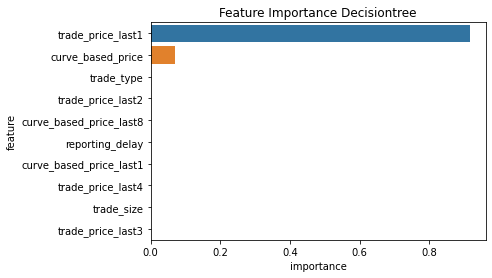

In [ ]:
#import seaborn as sns
#import matplotlib.pyplot as plt
#plt.figure(figsize=(10,6))
plt.title('Feature Importance Decisiontree')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/adeneyeoluwafunbi/benchmark-bond-trade-price-challenge


'https://jovian.ai/adeneyeoluwafunbi/benchmark-bond-trade-price-challenge'

In [ ]:
regressor2 = LinearRegression()
pipe2 = Pipeline(steps=[('transformer', transformer),
                      ('regressor2', regressor2)])
pipe2.fit(train_inputs, train_targets)   
print(regressor2)
preds2 = pipe2.predict(val_inputs)
print("model score: ", pipe2.score(val_inputs, val_targets))
print("model mae: ",mean_absolute_error(val_targets, preds2))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
model score:  0.9895416951097342
model mae:  0.6105146678495259


In [ ]:
importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance':  regressor2.coef_
}).sort_values('importance', ascending=False)

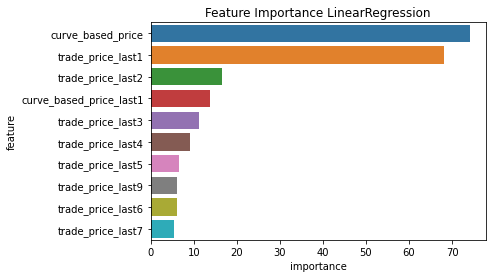

In [ ]:
plt.title('Feature Importance LinearRegression')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

In [ ]:
regressor3 = XGBRegressor(random_state=1)
pipe3 = Pipeline(steps=[('transformer', transformer),
                      ('regressor3', regressor3)])
pipe3.fit(train_inputs, train_targets)   
print(regressor3)
preds3 = pipe3.predict(val_inputs)
print("model score: ", pipe3.score(val_inputs, val_targets))
print("model mae: ",mean_absolute_error(val_targets, preds3))

[06:41:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
model score:  0.9916261687322874
model mae:  0.5495087387123776


In [ ]:
importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance':  regressor3.feature_importances_
}).sort_values('importance', ascending=False)

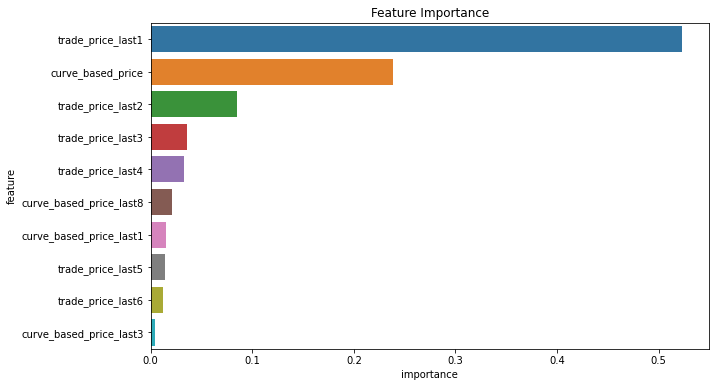

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

In [ ]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 20,20

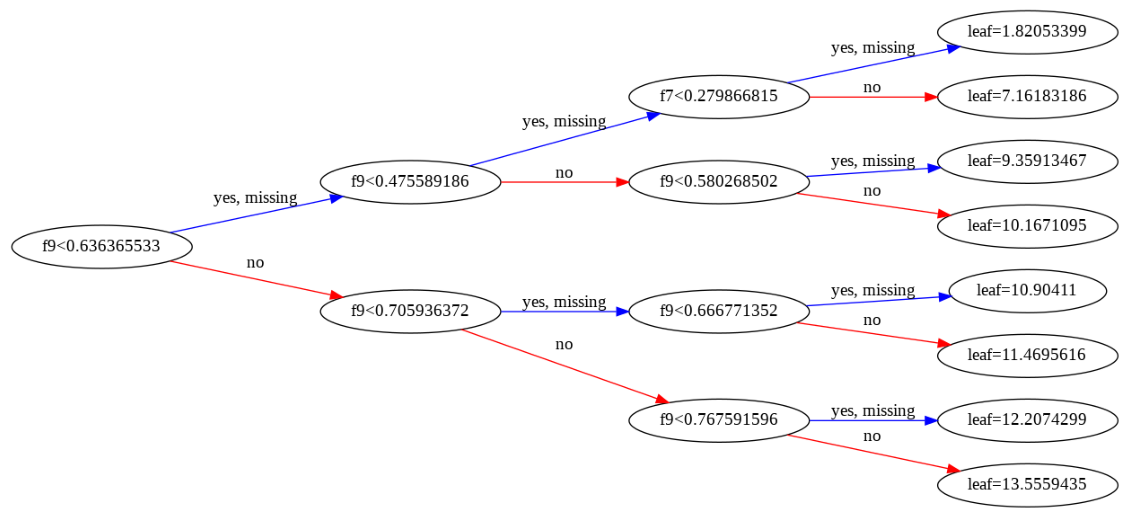

In [ ]:
plot_tree(regressor3, rankdir='LR');

XGBRegressor has the lowest mean absolute error among models deployed, let us see if we can improve on our score and mae by tuning some hyperparameter. 

In [ ]:
dic = {'predicted' : preds3.tolist(),'real_value' : val_targets.tolist()}


In [ ]:
compare = pd.DataFrame(dic)
compare.iloc[0:10]

,predicted,real_value
0,105.812874,109.4460
1,101.166603,101.5000
2,100.195961,100.3643
3,108.126175,108.4330
4,100.306946,99.7500
5,100.904305,100.5000
6,99.685234,99.9850
7,98.577103,98.9250
8,107.404198,106.0000
9,109.248222,109.9000


In [ ]:
def test_params(**params):
    regressor = XGBRegressor(random_state=1,**params)
    pipe = Pipeline(steps=[('transformer', transformer),
                      ('regressor', regressor)])
    pipe.fit(train_inputs, train_targets)   
    preds = pipe.predict(val_inputs)
    return 'Train score :{} \n val score : {} \n MAE : {} \n regressor : {}'.format(pipe.score(train_inputs, train_targets), pipe.score(val_inputs, val_targets),mean_absolute_error(val_targets, preds),regressor)

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/adeneyeoluwafunbi/benchmark-bond-trade-price-challenge


'https://jovian.ai/adeneyeoluwafunbi/benchmark-bond-trade-price-challenge'

In [ ]:
l_r = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] #0.10
m_dep = [3, 4, 5, 6, 8, 10, 12, 15] #15
m_c_w = [1, 3, 5, 7 ] #7
gam = [0.0, 0.1, 0.2 , 0.3, 0.4 ]
c_byt = [ 0.3, 0.4, 0.5 , 0.7 ] 

In [ ]:
def test():
  for i in l_r:
    for j in m_dep:
            yield test_params(learning_rate = i,max_depth = j)




In [ ]:
for e in test():
  print(e)



[17:15:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train score :0.9865067863535404 
 val score : 0.9867405125222081 
 MAE : 0.8199993840350513 
 regressor : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
[17:18:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train score :0.9874515024897739 
 val score : 0.9875612781539951 
 MAE : 0.799078329849326 
 regressor : XGBRegressor(base_score=0.5, booster='gbtree', colsa

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/adeneyeoluwafunbi/benchmark-bond-trade-price-challenge


'https://jovian.ai/adeneyeoluwafunbi/benchmark-bond-trade-price-challenge'

In [ ]:
test_params(learning_rate = 0.10,max_depth = 18,min_child_weight = 7 )


[06:46:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


"Train score :0.9983799140648275 \n val score : 0.993904990077567 \n MAE : 0.4267263968706537 \n regressor : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n             colsample_bynode=1, colsample_bytree=1, gamma=0,\n             importance_type='gain', learning_rate=0.1, max_delta_step=0,\n             max_depth=18, min_child_weight=7, missing=None, n_estimators=100,\n             n_jobs=1, nthread=None, objective='reg:linear', random_state=1,\n             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,\n             silent=None, subsample=1, verbosity=1)"

Using the above model tuning method I have selected hyperparamyter for the model I am going to use.

In [ ]:
model = XGBRegressor(random_state=1,learning_rate = 0.10,max_depth = 18,min_child_weight = 7)
pipeline1 = Pipeline(steps=[('transformer', transformer),
                      ('model', model)])
pipeline1.fit(train_inputs, train_targets)   
preds = pipeline1.predict(val_inputs)
print("model score: ", pipeline1.score(val_inputs, val_targets))
print("model mae: ",mean_absolute_error(val_targets, preds))

[07:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model score:  0.993904990077567
model mae:  0.4267263968706537


let us predict the test dataset

In [ ]:
test_df.shape

(61146, 58)

In [ ]:
train_inputs.shape

(572008, 58)

In [ ]:
input_cols = list(train_inputs.columns)
target_col = 'trade_price'

Let us save  parameters (weights and biases) of our trained model to disk, so that we needn't retrain the model from scratch each time we wish to use it. Along with the model, it's also important to save  pipelines,imputers, scalers, encoders and even column names. Anything that will be required while generating predictions using the model should be saved.

We can use the joblib module to save and load Python objects on the disk.

In [ ]:
import joblib

In [ ]:
bond_trade = {
    'model': model,
    'pipeline1': pipeline1,
    'transformer': transformer,
    'input_cols': input_cols,
    'target_col': target_col
}

In [ ]:
joblib.dump(bond_trade, 'bond_trade.joblib')

['bond_trade.joblib']

In [ ]:
bond_trade2 = joblib.load('bond_trade.joblib')

[08:07:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
test_preds2 = bond_trade2['pipeline1'].predict(test_df)


In [ ]:
test_preds2

array([ 98.05895, 115.98954, 104.69188, ..., 121.45617,  85.57467,
        96.45921], dtype=float32)

In [ ]:
predsX = pipeline1.predict(test_df)
predsX

array([ 98.05895, 115.98954, 104.69188, ..., 121.45617,  85.57467,
        96.45921], dtype=float32)

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/adeneyeoluwafunbi/benchmark-bond-trade-price-challenge


'https://jovian.ai/adeneyeoluwafunbi/benchmark-bond-trade-price-challenge'

In [ ]:
jovian.submit(assignment="zerotogbms-project")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/adeneyeoluwafunbi/benchmark-bond-trade-price-challenge
[jovian] Submitting assignment..
[jovian] Verify your submission at https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms/assignment/course-project-real-world-machine-learning-model
